</b> Solubility Prediction using Deep learning approach </b>

The dataset we will use for this time is the AqSolDb from Harvard University
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OVHAW8

We will try different deep learning architecture in this project 

</b>　EDA analysis </b>

In [4]:
#import useful library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.manifold, sklearn.cluster
import rdkit, rdkit.Chem, rdkit.Chem.Draw

In [6]:
#Load solution data and normalize the dat
soldata = pd.read_csv('curated-solubility-dataset.csv')
features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]
# standardize the features
soldata[feature_names] -= soldata[feature_names].mean()
soldata[feature_names] /= soldata[feature_names].std()

In [7]:
# Seeing the shape of dataset
soldata.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,0.683270,...,2.289205,0.737569,-0.815871,-0.332682,-0.424405,-0.921910,-0.985955,0.648787,-2.192419,-0.470078
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,-0.529284,...,-0.721283,-0.497979,0.711515,-0.332682,0.523762,0.902536,-0.526590,-0.441117,0.174863,0.080296
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,-0.684643,...,-0.544196,-0.745089,-0.052178,-0.332682,-0.424405,-0.313761,-0.716493,-0.662433,0.566007,-0.484194
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,2.658066,...,1.049592,2.621781,3.766287,-0.332682,-0.424405,2.726983,0.919699,2.809772,-2.192419,2.739160
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,0.846237,...,1.403767,1.077345,0.711515,4.214847,3.368260,2.726983,-0.092482,0.971332,-1.198556,0.553505


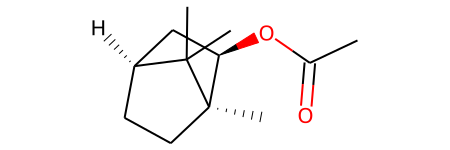

In [8]:
#try drawing molecule using Rdkit 
mol = rdkit.Chem.MolFromInchi(soldata.InChI[300])
mol

C:\Users\super\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


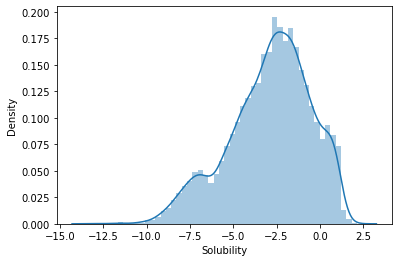

In [9]:
#seeing the distribution range of all target(solubility)
sns.distplot(soldata.Solubility)
plt.show()

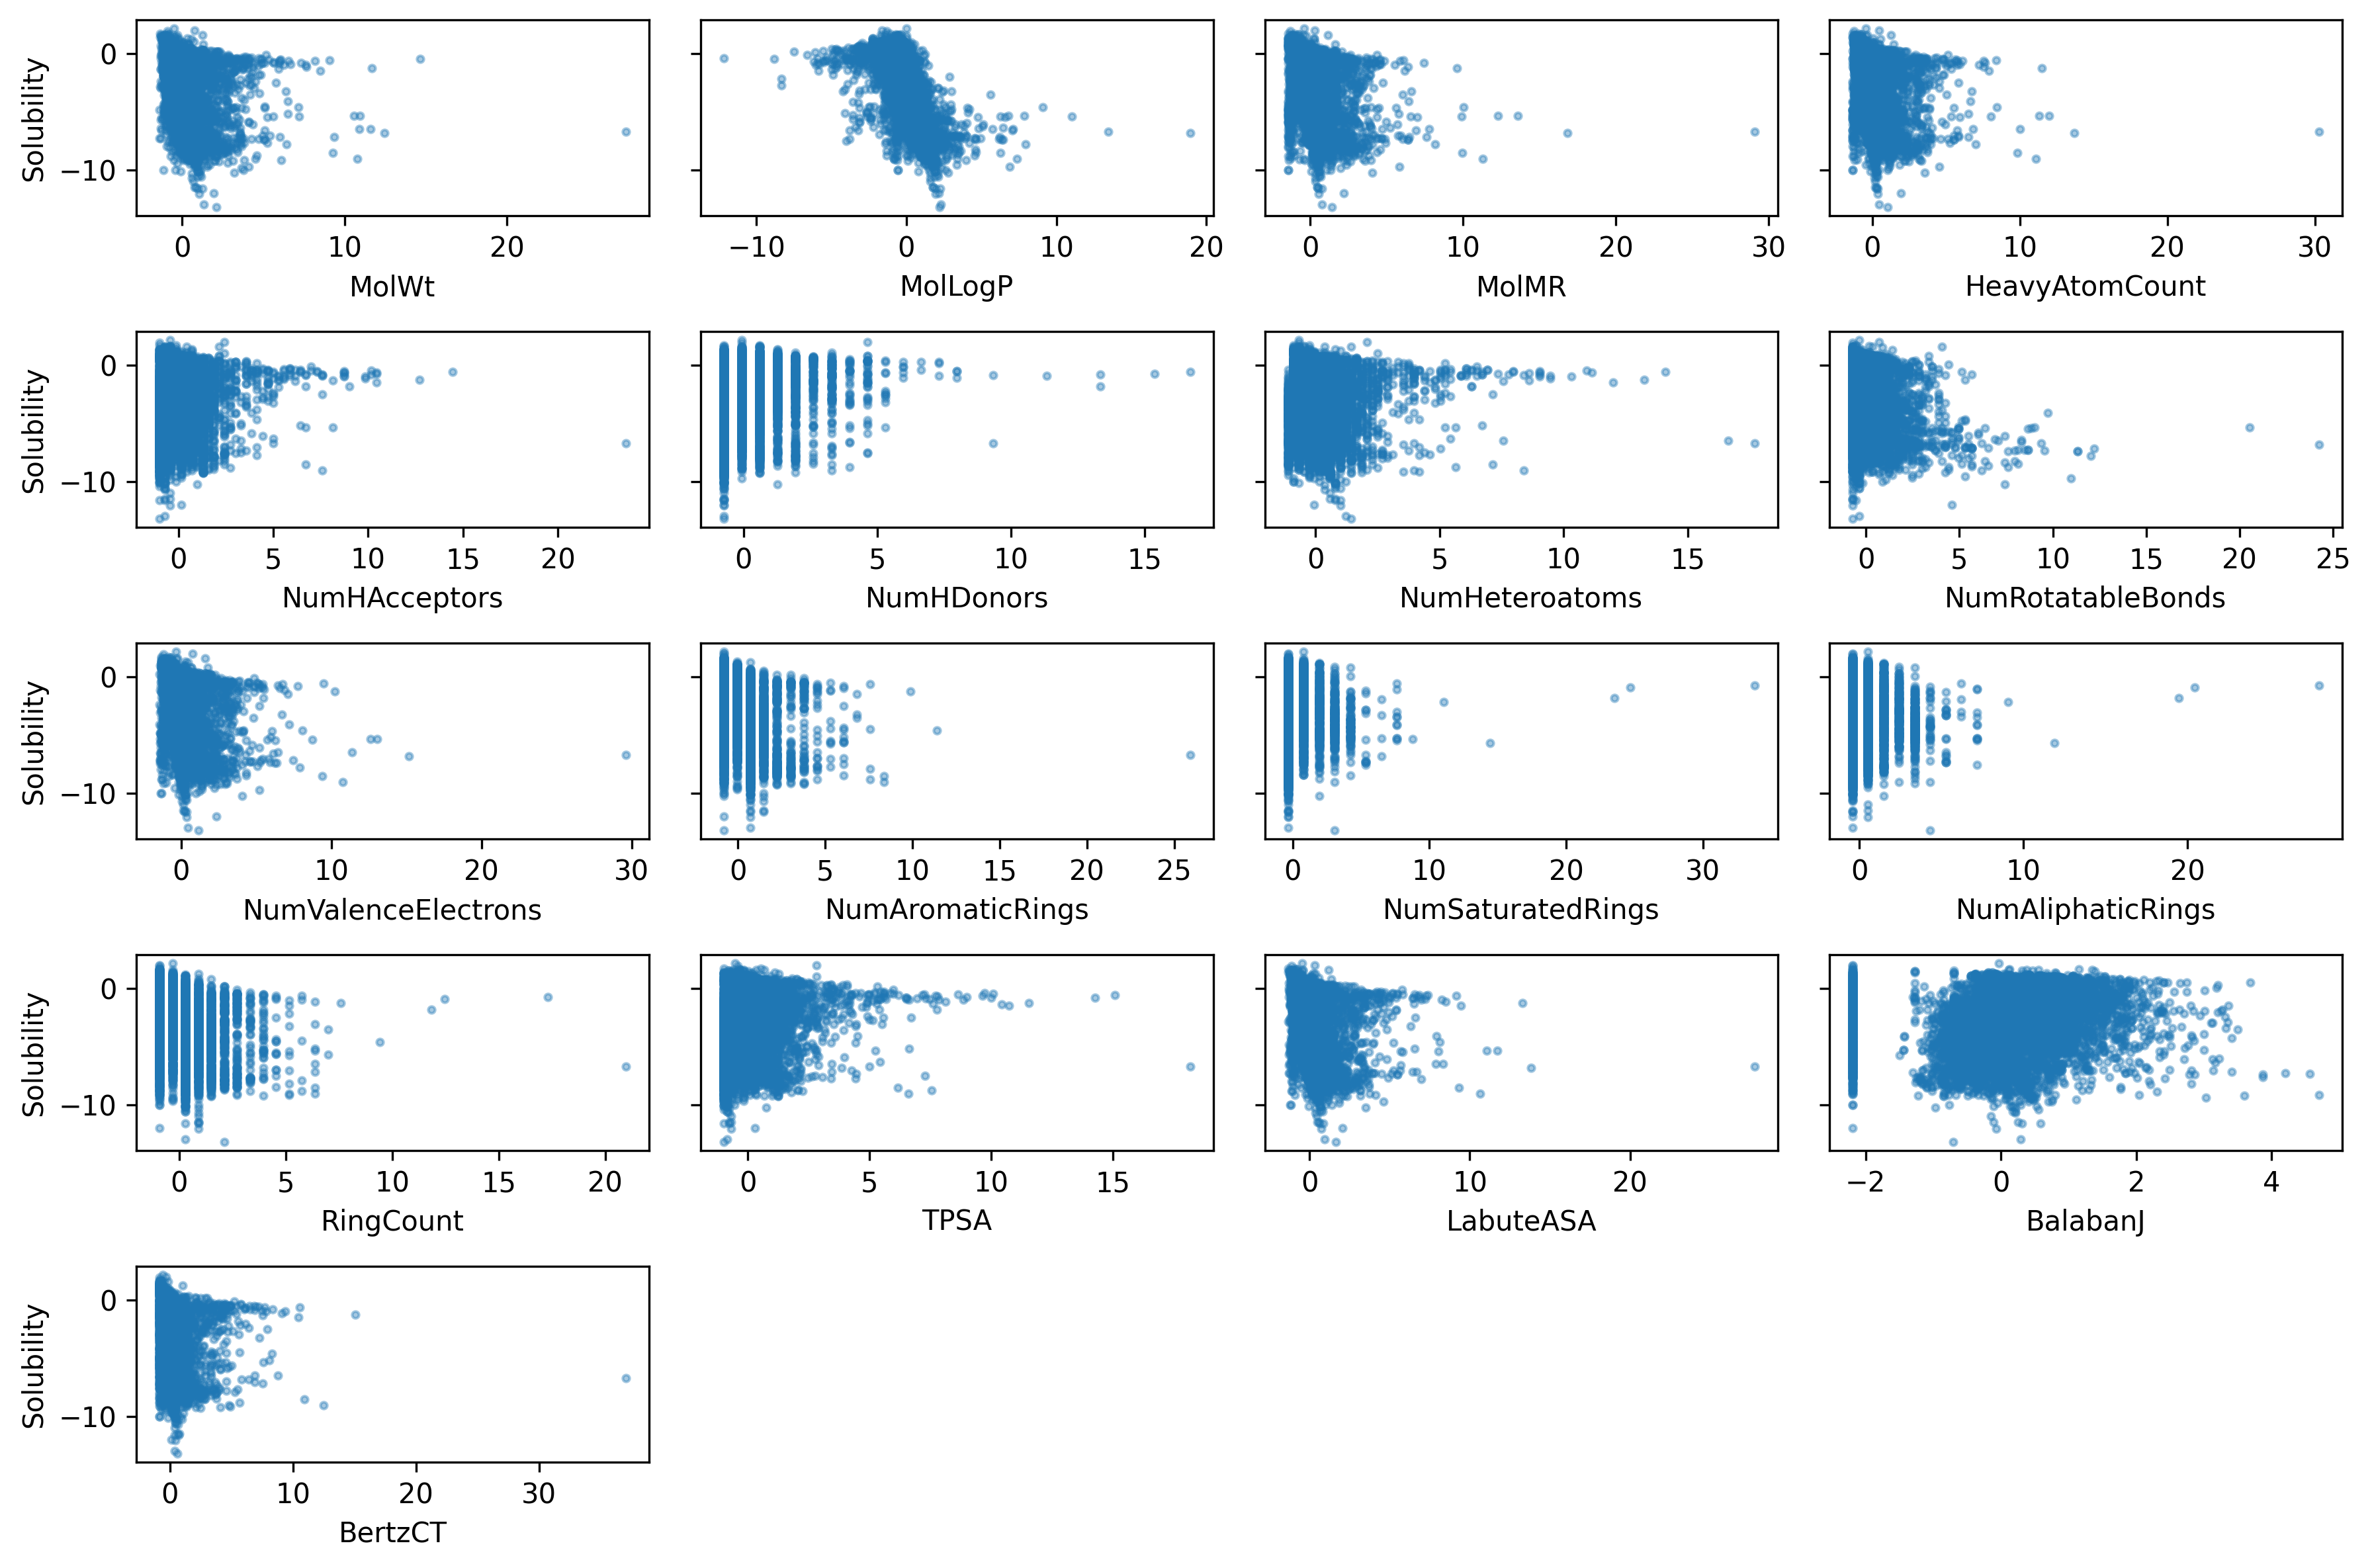

In [11]:
# plot of feature correlation
features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]

fig, axs = plt.subplots(nrows=5, ncols=4, sharey=True, figsize=(12, 8), dpi=300)
axs = axs.flatten()  # so we don't have to slice by row and column
for i, n in enumerate(feature_names):
    ax = axs[i]
    ax.scatter(
        soldata[n], soldata.Solubility, s=6, alpha=0.4
    )  # add some color
    if i % 4 == 0:
        ax.set_ylabel("Solubility")
    ax.set_xlabel(n)
# hide empty subplots
for i in range(len(feature_names), len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.show()

</b> Simple Artificial Neural Network model </b>

In [15]:
import tensorflow as tf

In [16]:
#Transform the data to be the useful form for implementing deep learning model in Keras
# We will use 10% as a test data 
# The target of prediction of the solubility 
full_data = tf.data.Dataset.from_tensor_slices(
    (soldata[feature_names].values, soldata["Solubility"].values)
)
N = len(soldata)
test_N = int(0.1 * N)
test_data = full_data.take(test_N).batch(16)
train_data = full_data.skip(test_N).batch(16)

In [17]:
#Simple Deep learning model
# We only need to define the output dimension - 32.
hidden_layer = tf.keras.layers.Dense(32, activation="tanh")
output_layer = tf.keras.layers.Dense(1)
model = tf.keras.Sequential()
model.add(hidden_layer)
model.add(output_layer)
# Try the model 
model(soldata[feature_names].values[:3]) # This will be the result of prediction

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-0.4420628 ],
       [-0.06860181],
       [-0.2576081 ]], dtype=float32)>

In [18]:
#complie the model
model.compile(optimizer="SGD", loss="mean_squared_error")
#fit the model on whole dataset
model.fit(train_data, epochs=50)

Epoch 1/50
562/562 [==============================] - 3s 944us/step - loss: 2.0780
Epoch 2/50
562/562 [==============================] - 1s 1ms/step - loss: 1.6089
Epoch 3/50
562/562 [==============================] - 1s 962us/step - loss: 1.5020
Epoch 4/50
562/562 [==============================] - 1s 950us/step - loss: 1.4446
Epoch 5/50
562/562 [==============================] - 1s 963us/step - loss: 1.4063
Epoch 6/50
562/562 [==============================] - 1s 1ms/step - loss: 1.3817
Epoch 7/50
562/562 [==============================] - 1s 1ms/step - loss: 1.3648
Epoch 8/50
562/562 [==============================] - 1s 1ms/step - loss: 1.3518
Epoch 9/50
562/562 [==============================] - 1s 1ms/step - loss: 1.3406
Epoch 10/50
562/562 [==============================] - 1s 1ms/step - loss: 1.3308
Epoch 11/50
562/562 [==============================] - 1s 1ms/step - loss: 1.3221
Epoch 12/50
562/562 [==============================] - 1s 1ms/step - loss: 1.3144
Epoch 13/50
562/5

In [19]:
#Compare the accuracy
yhat = np.squeeze(model.predict(test_data))
test_y = soldata["Solubility"].values[:test_N]

63/63 [==============================] - 0s 618us/step


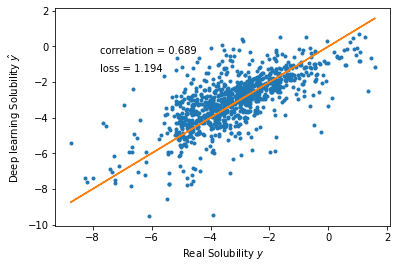

In [21]:
plt.plot(test_y, yhat, ".")
plt.plot(test_y, test_y, "-")
plt.xlabel("Real Solubility $y$")
plt.ylabel("Deep learning Solubility $\hat{y}$")
plt.text(
    min(test_y) + 1,
    max(test_y) - 2,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
)
plt.text(
    min(test_y) + 1,
    max(test_y) - 3,
    f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",
)
plt.show()

In [22]:
#Using MAPE as a indicator for comparing the accuracy
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(yhat, test_y)

0.6391451288837809

</b> Approach 2 Using GNN </b>

This time we will use GCN(Graph Convolutional Neural Network) as a one type of Graph Neural Network

To implement the neural network model we need to change the string into graph objects

one-hot node feature vectors, adjacency tensor with one-hot bond order being the feature vector

In [30]:
#focus element of the one-hot feature vectors are C,H,O
my_elements = {6: "C", 8: "O", 1: "H"}

In [44]:
def gen_smiles2graph(sml):
    # Return the graph from smiles 
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, 100))
    for i in m.GetAtoms():
        nodes[i.GetIdx(), i.GetAtomicNum()] = 1

    adj = np.zeros((N, N))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v] = 1
        adj[v, u] = 1
    adj += np.eye(N)
    return nodes, adj

In [45]:
#calculate the graph level feature
#We need to generate graph-level feature as an average value from all nodes 
class GRLayer(tf.keras.layers.Layer):
    """A GNN layer that computes average over all node features"""

    def __init__(self, name="GRLayer", **kwargs):
        super(GRLayer, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        nodes, adj = inputs
        #Using tf.reduce_mean to give an average value from all node(node represent the atom)
        reduction = tf.reduce_mean(nodes, axis=1)
        return reduction

In [46]:
#GCN layer
class GCNLayer(tf.keras.layers.Layer):
    """Implementation of GCN as layer"""

    def __init__(self, activation=None, **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # create trainable weights
        node_shape, adj_shape = input_shape
        self.w = self.add_weight(shape=(node_shape[2], node_shape[2]), name="w")

    def call(self, inputs):
        # split input into nodes, adj
        nodes, adj = inputs
        # compute degree
        degree = tf.reduce_sum(adj, axis=-1)
        # GCN equation
        new_nodes = tf.einsum("bi,bij,bjk,kl->bil", 1 / degree, adj, nodes, self.w)
        out = self.activation(new_nodes)
        return out, adj

In [78]:
ninput = tf.keras.Input(
    (
        None,
        100,
    )
)
ainput = tf.keras.Input(
    (
        None,
        None,
    )
)
# GCN block
# We adding four GCN layer 
x = GCNLayer("relu")([ninput, ainput])
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
# reduce to graph features
x = GRLayer()(x)
# standard layers (the readout)
# we using the activation function as tanh
x = tf.keras.layers.Dense(16, "tanh")(x)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=(ninput, ainput), outputs=x)

In [79]:
def example():
    for i in range(len(soldata)):
        graph = gen_smiles2graph(soldata.SMILES[i])
        sol = soldata.Solubility[i]
        yield graph, sol


data = tf.data.Dataset.from_generator(
    example,
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(
        (tf.TensorShape([None, 100]), tf.TensorShape([None, None])),
        tf.TensorShape([]),
    ),
)

In [80]:
test_data = data.take(200)
val_data = data.skip(200).take(200)
train_data = data.skip(400)

In [81]:
model.compile("adam", loss="mean_squared_error")
result = model.fit(train_data.batch(1), validation_data=val_data.batch(1), epochs=100)

Epoch 1/100
9582/9582 [==============================] - 29s 3ms/step - loss: 2.3686 - val_loss: 2.7247
Epoch 2/100
9582/9582 [==============================] - 40s 4ms/step - loss: 1.8852 - val_loss: 2.5703
Epoch 3/100
9582/9582 [==============================] - 32s 3ms/step - loss: 1.7802 - val_loss: 2.5520
Epoch 4/100
9582/9582 [==============================] - 27s 3ms/step - loss: 1.6610 - val_loss: 2.6942
Epoch 5/100
9582/9582 [==============================] - 27s 3ms/step - loss: 1.5782 - val_loss: 2.5583
Epoch 6/100
9582/9582 [==============================] - 27s 3ms/step - loss: 1.5447 - val_loss: 2.5682
Epoch 7/100
9582/9582 [==============================] - 28s 3ms/step - loss: 1.5113 - val_loss: 2.5947
Epoch 8/100
9582/9582 [==============================] - 32s 3ms/step - loss: 1.4914 - val_loss: 2.5899
Epoch 9/100
9582/9582 [==============================] - 31s 3ms/step - loss: 1.4491 - val_loss: 2.5966
Epoch 10/100
9582/9582 [==============================] - 31s 3m

9582/9582 [==============================] - 34s 4ms/step - loss: 1.0127 - val_loss: 1.9644
Epoch 80/100
9582/9582 [==============================] - 33s 3ms/step - loss: 1.0175 - val_loss: 1.9344
Epoch 81/100
9582/9582 [==============================] - 29s 3ms/step - loss: 1.0232 - val_loss: 1.7555
Epoch 82/100
9582/9582 [==============================] - 29s 3ms/step - loss: 1.0231 - val_loss: 1.8055
Epoch 83/100
9582/9582 [==============================] - 46s 5ms/step - loss: 1.0194 - val_loss: 1.9281
Epoch 84/100
9582/9582 [==============================] - 31s 3ms/step - loss: 1.0267 - val_loss: 1.8758
Epoch 85/100
9582/9582 [==============================] - 28s 3ms/step - loss: 1.0031 - val_loss: 1.8239
Epoch 86/100
9582/9582 [==============================] - 30s 3ms/step - loss: 0.9916 - val_loss: 1.8606
Epoch 87/100
9582/9582 [==============================] - 29s 3ms/step - loss: 0.9930 - val_loss: 1.8852
Epoch 88/100
9582/9582 [==============================] - 28s 3ms/st

In [83]:
yhat = model.predict(test_data.batch(1), verbose=0)[:, 0]
test_y = [y for x, y in test_data]

In [56]:
# We seeing that there is no improvement on the accuracy of the model 
# Accuracy is around 64%, however increasing the number of batch may increase the accuracy.

In [ ]:
# plot the graph of training loss and validation loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

We see that this is not a good plot, and the validation train's value seems to swing, hence we need more epoch to train the model, and other types of hyperparameter optimization

</b> Approach 3 using Recurrent Neural Network </b>

In this approach, we can also treat the smile string as a sequence for prediction. Recurrent neural network is the deep learning model that can capture and work well with a recurrent neural network.

We can use the same approach in natural language processing to perform this task

In [70]:
# filter out long smiles
smask = [len(s) <= 96 for s in soldata.SMILES]
print(f"Removed {soldata.shape[0] - sum(smask)} long SMILES strings")
filtered_soldata = soldata[smask]

# make tokenizer with 128 size vocab
vocab_size = 128
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    vocab_size, filters="", char_level=True
)
tokenizer.fit_on_texts(filtered_soldata.SMILES)

Removed 285 long SMILES strings


In [71]:
# acquire padded sequences
seqs = tokenizer.texts_to_sequences(filtered_soldata.SMILES)
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, padding="post")

# build transformed dataset
data = tf.data.Dataset.from_tensor_slices((padded_seqs, filtered_soldata.Solubility))
# now split into val, test, train and batch
N = soldata.shape[0]
split = int(0.1 * N)
test_data = data.take(split).batch(16)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(16), nontest.skip(split).shuffle(
    1000
).batch(16)

In [72]:
# Generate the Model 
model = tf.keras.Sequential()
model.add(
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=16, mask_zero=True)
)

# RNN layer
model.add(tf.keras.layers.GRU(32))
# a dense hidden layer
model.add(tf.keras.layers.Dense(32, activation="relu"))
# regression
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          2048      
                                                                 
 gru (GRU)                   (None, 32)                4800      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7,937
Trainable params: 7,937
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.compile(tf.optimizers.Adam(1e-2), loss="mean_squared_error")
result = model.fit(train_data, validation_data=val_data, epochs=100, verbose=0)

In [76]:
# evaluate on test data
yhat = []
test_y = []
for x, y in test_data:
    yhat.extend(model(x).numpy().flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

In [77]:
#calculate the MAPE value
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(yhat, test_y)

1.7213352660575296